In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from numba import jit, njit

import sys
sys.path.append('..')
from lib import *
from lib.maxent import *

In [43]:
def pairwise_distances(data, N=100, distance=disthamming, data2=None,
                       weights=None, weights2=None,
                       warning=True, prng=np.random):
    """Pairwise distances between N randomly picked pairs from data."""
    N = int(N)
    data = np.asarray(data)
    if data2 is None:
        data2 = data
    else:
        data2 = np.asarray(data2)
    distances = np.zeros(N)
    if weights is not None:
        weights = np.asarray(weights)
        dweights = np.zeros(N)
        if weights2 is None:
            weights2 = weights
        else:
            weights2 = np.asarray(weights2)
    if warning and (len(data)*len(data2) < 10 * N):
        print('warning: low amount of data, %g vs. %g', (len(data)*len(data2), N))
    randints1 = prng.randint(len(data), size=N)
    randints2 = prng.randint(len(data2), size=N)
    for i in range(N):
        inda, indb = randints1[i], randints2[i]
        while inda == indb:
            inda, indb = prng.randint(len(data)), prng.randint(len(data2))
        seqa, seqb = data[inda], data2[indb]
        distances[i] = distance(seqa, seqb)
        if weights is not None:
            dweights[i] = weights[inda] * weights2[indb]
    if weights is not None:
        return distances, dweights
    return distances


In [40]:
matrix = load_matrix('../maxent/data/test_matrix.csv.gz')

In [95]:
nsample = 1e6
bins = np.arange(0, 11, 1)
distances = pairwise_distances(matrix, N=nsample, distance=hammingdist_jit)
hist, _ = np.histogram(distances, bins=bins-0.5)

In [96]:
%timeit -t pairwise_distances(matrix, N=nsample, distance=hammingdist_jit)

1.58 s ± 151 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [99]:
@njit
def pairwise_distances_jit(data, N=100, data2=None, normalize=False):
    N = int(N)
    data = np.asarray(data)
    if data2 is None:
        data2 = data
    else:
        data2 = np.asarray(data2)
    num_rows = 2*int(N**.5)
    indices = np.random.choice(matrix.shape[0], num_rows, replace=False)
    data = data[indices[:num_rows//2]]
    data2 = data2[indices[num_rows//2:]]
    L = matrix.shape[1]
    hist = np.zeros(L+1)
    for i in range(len(data)):
        for j in range(len(data2)):
            dist = hammingdist_jit(data[i, :], data2[j, :])
            hist[dist] += 1
    if normalize:
        hist /= len(data)*len(data2)
    return hist

In [104]:
%timeit -t pairwise_distances_jit(matrix, N=1e8)

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.
13.7 s ± 469 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [100]:
nsample = 1e7
bins = np.arange(0, 11, 1)
distances = pairwise_distances(matrix, N=nsample, distance=hammingdist_jit)
hist, _ = np.histogram(distances, bins=bins-0.5)

In [101]:
direct = pairwise_distances_jit(matrix, N=nsample)

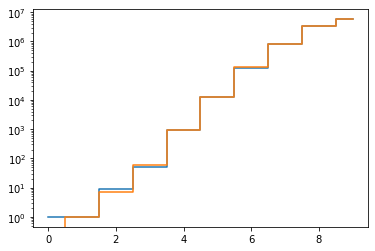

In [103]:
plt.step(bins[:-1], direct, where='mid')
plt.step(bins[:-1], hist, where='mid')
plt.yscale('log')